In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2

In [2]:
# dataset available at https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## Configuration

In [3]:
class CFG:
    epochs = 2
    lr = 0.01
    batch_size = 16

    # we will use efficientnet and we will fine tune it (transfer learning)
    model_name = 'tf_efficientnet_b4_ns'
    img_size = 224

    DATA_DIR = 'chest_xray'
    TEST = 'test'
    TRAIN = 'train'
    VALIDATION = 'val'


# on my pc gpu training is about 3x faster than cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Active device: {device}')

Active device: cuda


## Image Transformation and Load Dataset

In [4]:
from torchvision import transforms as T, datasets
from utils import show_image

In [5]:
train_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees=(-5, 5)),
    T.RandomHorizontalFlip(),
    T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.3)),
    T.ToTensor(),  # (h, w, c) -> (c, h, w)
    # use the efficientnet values here -> this normalizes across channels
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),  # (h, w, c) -> (c, h, w)
    # use the efficientnet values here -> this normalizes across channels
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),  # (h, w, c) -> (c, h, w)
    # use the efficientnet values here -> this normalizes across channels
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)
validation_path = os.path.join(CFG.DATA_DIR, CFG.VALIDATION)

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
validation_dataset = datasets.ImageFolder(validation_path, transform=validation_transform)

In [7]:
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')
print(f'Validation set size: {len(validation_dataset)}')

Training set size: 5216
Test set size: 624
Validation set size: 16


In [8]:
print(train_dataset.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}


4252


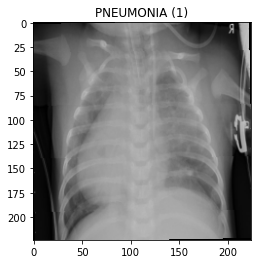

3625


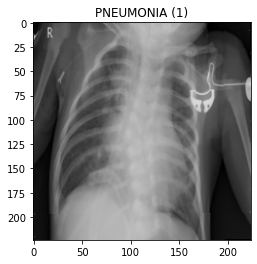

2642


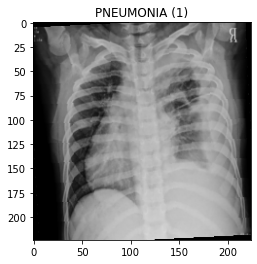

1649


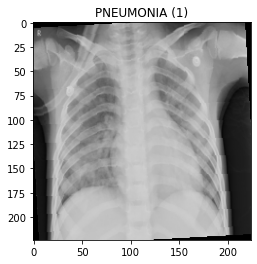

5165


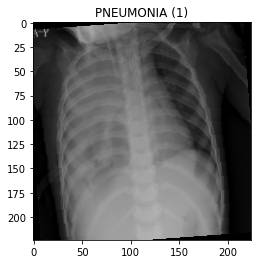

In [9]:
# plot a few examples
for i in range(5):
    r = np.random.randint(0, len(train_dataset) - 1)
    print(r)
    image, label = train_dataset[r]
    show_image(image, label, device)

## Load Dataset Into Batches

In [10]:
from torch.utils.data import DataLoader
from utils import show_grid

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=CFG.batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=CFG.batch_size, shuffle=True)

In [12]:
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of test batches: {len(test_loader)}')
print(f'Number of validation batches: {len(validation_loader)}')

print(f'Total training examples: {len(train_loader.dataset)}')

Number of training batches: 326
Number of test batches: 39
Number of validation batches: 1
Total training examples: 5216


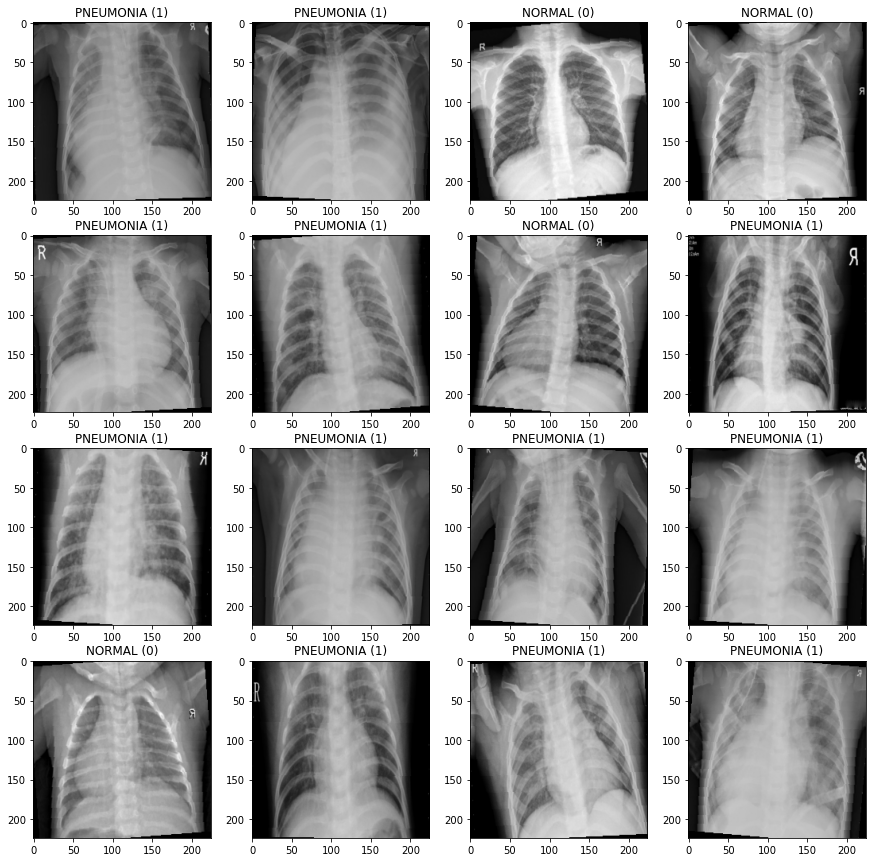

In [13]:
# plot a batch
data_iter = iter(train_loader)
images, labels = data_iter.next()

show_grid(images, labels, device, n_cols=4)

## Fine Tuning the EfficientNet Model

In [14]:
from torch import nn
import torch.nn.functional as F
import timm

model = timm.create_model(CFG.model_name, pretrained=True)

# here is an excerpt of the printout of the model
# '''
#         (conv_pwl): Conv2d(2688, 448, kernel_size=(1, 1), stride=(1, 1), bias=False)
#         (bn3): BatchNorm2d(448, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#   )
#   (conv_head): Conv2d(448, 1792, kernel_size=(1, 1), stride=(1, 1), bias=False)
#   (bn2): BatchNorm2d(1792, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
#   (act2): SiLU(inplace=True)
#   (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
#   (classifier): Linear(in_features=1792, out_features=1000, bias=True)
# )
# '''

# freeze the weights of the model up to the last layer
for param in model.parameters():
    param.requires_grad = False

# now change the last layer 'classifier'
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),  # we probably do not need the dropout here, but it won't hurt
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
    # we treat the problem as a multi-class classification out_features=1 would also work
    # we do not need to specify a softmax activation here since PyTorch takes raw inputs for its CrossEntropyLoss
)

# this is an excerpt of the printout of the model now
# '''
#         (conv_pwl): Conv2d(2688, 448, kernel_size=(1, 1), stride=(1, 1), bias=False)
#         (bn3): BatchNorm2d(448, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#   )
#   (conv_head): Conv2d(448, 1792, kernel_size=(1, 1), stride=(1, 1), bias=False)
#   (bn2): BatchNorm2d(1792, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
#   (act2): SiLU(inplace=True)
#   (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
#   (classifier): Sequential(
#     (0): Linear(in_features=1792, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Dropout(p=0.3, inplace=False)
#     (3): Linear(in_features=512, out_features=256, bias=True)
#     (4): ReLU()
#     (5): Linear(in_features=256, out_features=2, bias=True)
#   )
# )
# '''

In [15]:
from torchsummary import summary

summary(model.to(device), input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 112, 112]               0
           Conv2d-12         [-1, 24, 112, 112]           1,152
      BatchNorm2d-13         [-1, 24, 112, 112]              48
         Identity-14         [-1, 24, 1

## Simple Trainer

In [16]:
from utils import accuracy
from tqdm import tqdm

In [17]:
class PneumoniaTrainer():
    def __init__(self, criterion, optimizer, lr_schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_schedular = lr_schedular
        self.train_metrics = []
        self.test_metrics = []

    def train_batch_loop(self, model, train_loader):
        train_acc = 0.0
        train_loss = 0.0
        print('Training')
        for images, labels in tqdm(train_loader):
            # move the images and labels to the correct devices
            images = images.to(device)
            labels = labels.to(device)

            # calculate model output and loss
            logits = model(images)
            loss = self.criterion(logits, labels)

            # update the weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # add the accuracy and loss
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        return train_acc / len(train_loader), train_loss / len(train_loader)

    def test_batch_loop(self, model, test_loader, test_validation='Test'):
        train_acc = 0.0
        train_loss = 0.0
        print(f'Calculating {test_validation} Metrics')
        for images, labels in tqdm(test_loader):
            # move the images and labels to the correct devices
            images = images.to(device)
            labels = labels.to(device)

            # calculate model output and loss
            logits = model(images)
            loss = self.criterion(logits, labels)

            # add the accuracy and loss
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        return train_acc / len(test_loader), train_loss / len(test_loader)

    def fit(self, model, train_loader, test_loader, validation_loader, epochs):
        # move the model to the correct device
        model = model.to(device)
        test_max_acc = 0
        for epoch in range(epochs):
            print(f'++++++++++++++++')
            print(f'Starting epoch {epoch + 1}')

            # set the model to train mode -> turn on dropout and batch norm
            model.train()

            # get the train and test acc and loss
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, train_loader)
            self.train_metrics.append((avg_train_acc, avg_train_loss))
            # turn off the batch norm and dropout layers
            model.eval()
            avg_test_acc, avg_test_loss = self.test_batch_loop(model, test_loader)
            self.test_metrics.append((avg_test_acc, avg_test_loss))

            # print some metrics
            print(f'End of epoch {epoch + 1}')
            print(f'\tTrain metrics:\n\t\tacc: {avg_train_acc * 100:.4f}%\n\t\tloss: {avg_train_loss:.4f}')
            print(f'\tTest metrics:\n\t\tacc: {avg_test_acc * 100:.4f}%\n\t\tloss: {avg_test_loss:.4f}')

            # save the best model according to test accuracy
            if avg_test_acc >= test_max_acc:
                print(f'Test accuracy increased from {test_max_acc * 100:.2f}% --> {avg_test_acc * 100:.2f}%')
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                test_max_acc = avg_test_acc

        print('+++Training Finished.+++')
        # report the final validation loss and acc
        validation_acc, validation_loss = self.test_batch_loop(model, validation_loader, test_validation='Validation')
        print(f'Validation metrics:\n\tacc: {validation_acc * 100:.2f}\n\tloss: {validation_loss:.2f}')

## Train the Model

In [18]:
from torch import optim

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
lr_schedular = None

pneumonia_trainer = PneumoniaTrainer(criterion, optimizer, lr_schedular)
pneumonia_trainer.fit(model, train_loader, test_loader, validation_loader, CFG.epochs)

++++++++++++++++
Starting epoch 1
Training


100%|██████████| 326/326 [02:44<00:00,  1.98it/s]


Calculating Test Metrics


100%|██████████| 39/39 [00:16<00:00,  2.38it/s]


End of epoch 1
	Train metrics:
		acc: 88.3819%
		loss: 0.3087
	Test metrics:
		acc: 84.9359%
		loss: 0.4805
Test accuracy increased from 0.00% --> 84.94%
++++++++++++++++
Starting epoch 2
Training


100%|██████████| 326/326 [02:45<00:00,  1.97it/s]


Calculating Test Metrics


100%|██████████| 39/39 [00:17<00:00,  2.26it/s]


End of epoch 2
	Train metrics:
		acc: 90.3949%
		loss: 0.2402
	Test metrics:
		acc: 81.0897%
		loss: 0.4004
+++Training Finished.+++
Calculating Validation Metrics


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Validation metrics:
	acc: 75.00
	loss: 0.42


## Explore the Results and do Predictions

In [23]:
from utils import view_classify

In [24]:
# this method overrides the trainable parameters associated with the model object to those found in the .pt file
model.load_state_dict(torch.load('PneumoniaModel.pt', map_location=device))

# set to eval mode
model.eval()
avg_test_acc, avg_test_loss = pneumonia_trainer.test_batch_loop(model, test_loader)
print(f'Test acc: {avg_test_acc:.4f}')
print(f'Test loss: {avg_test_loss:.4f}')

Calculating Test Metrics


100%|██████████| 39/39 [00:17<00:00,  2.18it/s]

Test acc: 0.8494
Test loss: 0.4805


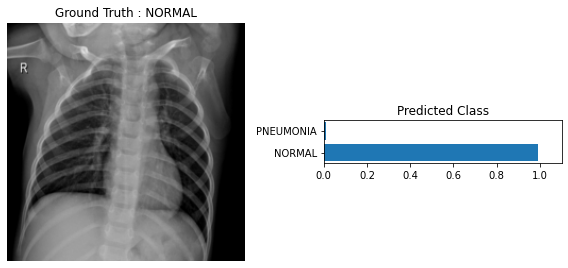

In [28]:
r = np.random.randint(0, len(validation_dataset) - 1)
image, label = validation_dataset[r]
pred = model(image.to(device).unsqueeze(0)) # (3, 224, 224) -> (1, 3, 224, 224) where 1 is the batch size
pred = F.softmax(pred, dim=1)

view_classify(image, pred, label)